# Neurotransmitters in plasma/brain

- using a QIIME2 2021.11 conda environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact, Visualization

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.diversity.beta import unweighted_unifrac
from skbio.stats import distance, ordination
from skbio import DistanceMatrix

from sklearn.decomposition import PCA

%matplotlib inline

## Read in data

### Metadata

In [2]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")
metadata.head()

,#SampleID,MetaboSampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
0,GT.063_N,18,2,B07,48,TTAACAAGGCAA,GTGYCAGCMGCCGCGGTAA,515rcbc222,63,Red,Green Tea,15.3,62.55,10/13/21,BSC,MK
1,GT.063_R,3,1,E01,49,TGATGTGCTAAG,GTGYCAGCMGCCGCGGTAA,515rcbc48,63,Red,Green Tea,39.9,51.15,10/13/21,BSC,MK
2,GT.066_B,17,2,A09,54,CCAGGACAGGAA,GTGYCAGCMGCCGCGGTAA,515rcbc200,66,Red,Green Tea,18.6,67.90,10/13/21,BSC,MK
3,GT.066_N,29,1,F12,55,AACTCAATAGCG,GTGYCAGCMGCCGCGGTAA,515rcbc167,66,Red,Green Tea,32.9,41.80,10/13/21,BSC,MK
4,GT.074_N,2,2,C12,52,GATATACCAGTG,GTGYCAGCMGCCGCGGTAA,515rcbc227,74,Red,Green Tea,9.8,38.75,10/13/21,BSC,MK


In [4]:
metadata = metadata.set_index("MetaboSampleID").sort_index()

### Plasma

In [22]:
plasma = pd.read_csv("../neurotransmitters/plasma_neurotransmitters.txt", 
                     sep="\t", index_col="SampleID")
plasma = plasma.rename(columns={"Unnamed: 2": "Time"})
plasma = plasma.sort_index()

### Brain

In [24]:
brain = pd.read_csv("../neurotransmitters/brain_neurotransmitters.txt",
                    sep="\t", index_col="SampleID")
brain = brain.sort_index()

### Microbiome

In [14]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

In [15]:
tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

In [16]:
microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

In [21]:
microbiome_index_mapper = metadata.reset_index().set_index("#SampleID")["MetaboSampleID"].to_dict()

new_microbiome_index = [int(microbiome_index_mapper[x]) for x in list(microbiome.index)]
microbiome.index = new_microbiome_index
microbiome = microbiome.sort_index()

## Analysis

### Neurotransmitter beta diversity

### PCA

In [26]:
plasma

,Sample,Time,Melatonin_pos,NAM,Pyridoxal and Isopyridoxal,Anthranilic Acid,Kynurenic acid,Metanephrine,3-hydroxy-athranilic acid (3-HAA),Serotonin,...,N-Formylkynurenine,Tryptophan,5-Hydroxyindole-3-acetic acid (5-HIAA),Glycyl-Phenylalanine,3-Hydroxy Kynurenine,Tyrosine,5-Hydroxytryptophan,Arginyl-Phenylalanine,GABA,NAD+
SampleID,,,,,,,,,,,,,,,,,,,,,
1,GF-2 July-PL.d,2/5/22 6:20,0.0000,1087.3600,0.0000,0.000,24.0600,0.0000,0.0000,609.6400,...,0.0000,51384.0300,0.0000,31.9800,0.0000,44795.050,0.0000,0.0000,76.5400,28.0500
10,GLD090-R-PL.d,2/5/22 2:14,0.0000,946.4000,0.0000,0.000,24.2200,0.0000,0.0000,3420.0800,...,12.4000,40574.6500,0.0000,0.0000,0.0000,23768.510,0.0000,0.0000,68.4200,26.9800
11,GLD113-R-PL.d,2/5/22 7:01,0.0000,456.1400,0.0000,0.000,8.1900,0.0000,0.0000,2674.6000,...,0.0000,40376.6300,0.0000,0.0000,0.0000,16758.400,0.0000,0.0000,63.2300,30.5500
12,GF-R Aug-PL.d,2/5/22 8:02,0.0000,324.6900,0.0000,0.000,3.8100,0.0000,0.0000,1799.2600,...,17.6600,50667.3700,0.0000,0.0000,0.0000,21993.940,0.0000,0.0000,49.0400,26.4000
13,GLD116-N-PL.d,2/5/22 7:42,0.0000,1108.6300,0.0000,0.000,16.7600,0.0000,0.0000,1565.8100,...,20.8900,39459.6600,0.0000,0.0000,0.0000,25671.040,0.0000,0.0000,58.6900,873.7300
14,GF-1 July-PL.d,2/5/22 3:36,0.0000,1048.3300,0.0000,0.000,22.4600,0.0000,0.0000,517.4800,...,32.1900,46919.8400,0.0000,0.0000,0.0000,43410.850,0.0000,0.0000,94.7700,101.5200
15,GLD101-R-PL.d,2/4/22 23:30,0.0000,293.3700,0.0000,0.000,7.2400,0.0000,0.0000,1792.5700,...,0.0000,45337.9600,0.0000,0.0000,0.0000,24867.690,0.0000,0.0000,78.7600,39.8100
16,GLD086-N-PL.d,2/5/22 4:17,0.0000,358.5200,0.0000,0.000,8.7200,0.0000,0.0000,299.8000,...,0.0000,51132.3700,0.0000,0.0000,0.0000,32910.850,0.0000,0.0000,44.0200,10.9600
17,GLD066-B-PL.d,2/5/22 6:40,4.4000,259.2300,253.8100,0.000,9.2500,0.0000,0.0000,134.2600,...,0.0000,30537.0700,0.0000,0.0000,0.0000,23590.100,0.0000,0.3800,67.3600,0.0000


In [28]:
plasma_pca = PCA(n_components=3)
plasma_pca_res = plasma_pca.fit_transform(plasma.drop(["Sample", "Time"],axis=1).drop("LLOQ (ng/ml)"))

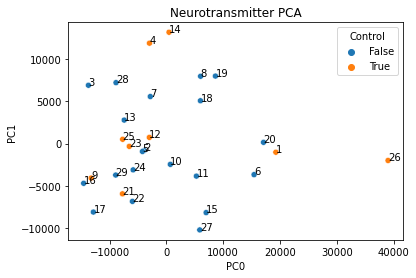

In [30]:
ax = sns.scatterplot(x=plasma_pca_res[:,0], y=plasma_pca_res[:,1],
                     hue=metadata["PID"]=="Control")
ax.set(xlabel="PC0", ylabel="PC1", title="Plasma Neurotransmitter PCA")
plt.legend(title="Control")

for i, name in enumerate(metadata.index):
    ax.text(x=plasma_pca_res[i,0],
            y=plasma_pca_res[i,1],
            s=name)

## What compounds are associated with microbiome composition?

In [40]:
plasma_samples = plasma.drop(["Sample", "Time"],axis=1).drop("LLOQ (ng/ml)")
brain_samples = brain.drop("Sample",axis=1).drop("LLOQ")

In [41]:
microbiome_u_uni = Artifact.load("../microbiome/core-metrics/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

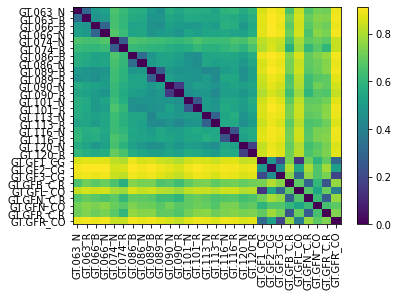

In [42]:
microbiome_u_uni

In [43]:
microbiome_u_uni_df = microbiome_u_uni.to_data_frame()

new_microbiome_u_uni_index = [int(microbiome_index_mapper[x]) for x in list(microbiome_u_uni_df.index)]
microbiome_u_uni_df.index = new_microbiome_u_uni_index
microbiome_u_uni_df = microbiome_u_uni_df.rename(index=microbiome_index_mapper, 
                                                 columns=microbiome_index_mapper)
microbiome_u_uni = DistanceMatrix(microbiome_u_uni_df, ids=microbiome_u_uni_df.index)

In [44]:
def make_euclidean_distance_matrix(data, ids):
    data = np.array(data)
    
    matrix_shape = (data.shape[0], data.shape[0])
    out_matrix = np.empty(matrix_shape)
    
    for i, entry in enumerate(data):
        for j, entry_2 in enumerate(data):
            if i==j:
                out_matrix[i,i] = 0
            elif i<j:
                diff = np.abs(entry_2 - entry)
                out_matrix[i,j] = diff
                out_matrix[j,i] = diff
                
            else:
                pass
    
    return DistanceMatrix(out_matrix, ids=ids)

### Plasma

In [46]:
plasma_index = [int(x) for x in plasma_samples.index]
plasma_mantel_results_u = pd.DataFrame(index=plasma_samples.columns,
                                            columns=["corr","p"])

for col in plasma_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(plasma_samples[col], 
                                                     ids=plasma_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson")
    
    plasma_mantel_results_u.loc[col,"corr"] = corr
    plasma_mantel_results_u.loc[col,"p"] = p
    
    print("\n================================")
    print(f"Mantel on {col} and unweighted UniFrac:")
    print(f"corr = {corr}, p = {p}")


Mantel on Melatonin_pos  and unweighted UniFrac:
corr = -0.06527616032849705, p = 0.491

Mantel on NAM  and unweighted UniFrac:
corr = 0.031948684093279674, p = 0.627

Mantel on Pyridoxal and Isopyridoxal  and unweighted UniFrac:
corr = -0.07159262799415557, p = 0.505

Mantel on Anthranilic Acid  and unweighted UniFrac:
corr = nan, p = nan


/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Mantel on Kynurenic acid  and unweighted UniFrac:
corr = 0.1837811785584106, p = 0.024

Mantel on Metanephrine  and unweighted UniFrac:
corr = nan, p = nan

Mantel on 3-hydroxy-athranilic acid (3-HAA)  and unweighted UniFrac:
corr = nan, p = nan

Mantel on Serotonin  and unweighted UniFrac:
corr = -0.02101432711348183, p = 0.803

Mantel on Xanthurenic Acid  and unweighted UniFrac:
corr = 0.0878952332705956, p = 0.133

Mantel on Dopamine  and unweighted UniFrac:
corr = 0.09902669899286863, p = 0.138

Mantel on N-Methylnicotinamide  and unweighted UniFrac:
corr = 0.023360023746325766, p = 0.798

Mantel on Phenylalanine  and unweighted UniFrac:
corr = -0.025791061591218988, p = 0.727

Mantel on L-Kynurenine  and unweighted UniFrac:
corr = 0.0073782708532734624, p = 0.948

Mantel on Picolinic acid  and unweighted UniFrac:
corr = nan, p = nan

Mantel on N-Formylkynurenine  and unweighted UniFrac:
corr = -0.04768715647486607, p = 0.432

Mantel on Tryptophan  and unweighted UniFrac:
corr = 0

In [47]:
plasma_mantel_results_u["Avg Abundance"] = plasma_samples.sum(axis=0)/plasma_samples.shape[0]
plasma_mantel_results_u["P<0.05"] = plasma_mantel_results_u["p"]<0.05
plasma_mantel_results_u["Log10 Avg Abundance"] = plasma_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

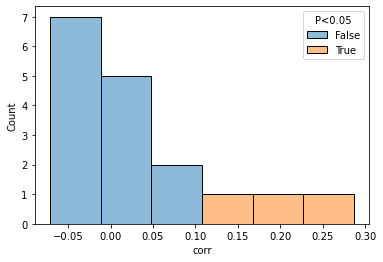

In [48]:
ax = sns.histplot(x = plasma_mantel_results_u["corr"], hue = plasma_mantel_results_u["P<0.05"])

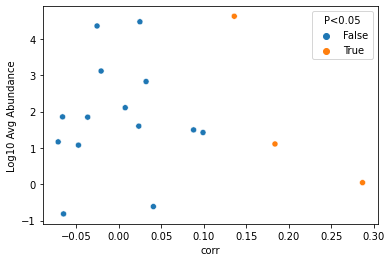

In [49]:
ax = sns.scatterplot(data=plasma_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [50]:
plasma_mantel_results_u[plasma_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Glycyl-Phenylalanine,0.286914,0.035,1.102759,True,0.042520
Kynurenic acid,0.183781,0.024,12.796897,True,1.107108
Tryptophan,0.13584,0.047,42035.598276,True,4.623617


In [51]:
plasma_mantel_results_u[plasma_mantel_results_u["P<0.05"]].sort_values("Avg Abundance")

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Glycyl-Phenylalanine,0.286914,0.035,1.102759,True,0.042520
Kynurenic acid,0.183781,0.024,12.796897,True,1.107108
Tryptophan,0.13584,0.047,42035.598276,True,4.623617


### Brain

In [52]:
brain_samples_index = [int(x) for x in brain_samples.index]
brain_mantel_results_u = pd.DataFrame(index=brain_samples.columns,
                                            columns=["corr","p"])

for col in brain_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(brain_samples[col], 
                                                     ids=brain_samples_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson")
    
    brain_mantel_results_u.loc[col,"corr"] = corr
    brain_mantel_results_u.loc[col,"p"] = p

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [53]:
brain_mantel_results_u["Avg Abundance"] = brain_samples.sum(axis=0)/brain_samples.shape[0]
brain_mantel_results_u["P<0.05"] = brain_mantel_results_u["p"]<0.05
brain_mantel_results_u["Log10 Avg Abundance"] = brain_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

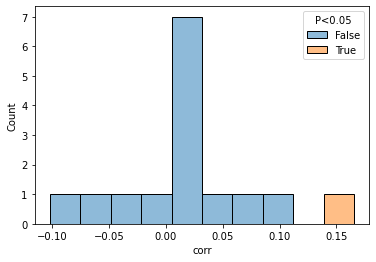

In [55]:
ax = sns.histplot(x = brain_mantel_results_u["corr"], hue = brain_mantel_results_u["P<0.05"])

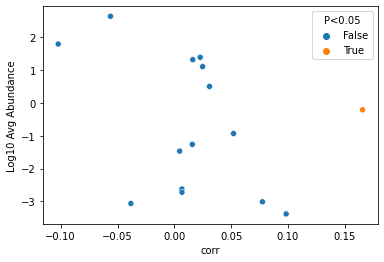

In [56]:
ax = sns.scatterplot(data=brain_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [57]:
brain_mantel_results_u[brain_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False).head(20)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Dopamine,0.165621,0.023,0.616448,True,-0.210033
